## N PROTEIN BINDING MODELLING

In this notebook, I will create a model for predicting the binding affinity of coronavirus N_proteins to host-cell RNA. A base model would be built for comparison purposes using the whole sequence of detected RNAs. However, the main model would use only sequences of the binding regions of N_protein. The dataset to be used is a CRAC data which has binding affinities of a particular N protien to a particular mRNA with 9522 RNAs and 4 N proteins.
from sklearn. Also, the gene sequences are in fasta format; `biomart_transcriptome_all.fasta`. CRAC data is in `SB20201008_hittable_unique.xlsx`.
First I import the relevant libraries for the work

In [7]:
# python
import itertools
import joblib

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# data processing and visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from scipy import stats

Next I write helper function; `possible_kmers` to output the possible kmers of *ATGC* of length k and `generate_kmers` to generate kmers from an input sequence

In [8]:
def possible_kmers(k):
    """All permutation of DNA sequence based on size
        Args:
            - k (int); number of bases
        Return:
            - (list) all possible kmers of lenght k
    """
    
    kmers = []
    
    for output in itertools.product('ATGC', repeat=k):
        kmers.append(''.join(list(output)))
        
    return kmers


def generate_kmers(sequence, window, slide=1):
    """Make kmers from a sequence
        Args:
            - sequence (str); sequence to compute kmer
            - window (int); size of kmers
            - slide (int); no of bases to move 'window' along sequence
            default = 1
            
        Return:
            - 'list' object of kmers
        
        Example:
            - >>> DNA_kmers('ATGCGTACC', window=4, slide=4)
                ['ATGC', 'GTAC']
    """
    
    all_possible_seq = []
    kmers = []
    
    for base in range(0, len(sequence), slide): # indices
        # extend by window
        all_possible_seq.append(sequence[base:base + window]) 
        
    # remove all kmers != window    
    for seq in all_possible_seq:
        if len(seq) == window:
            kmers.append(seq)

    return kmers

Next, I read and process the data, `biomart_transcriptome_all` which contains all the transcripts and sequence of humans. Also, I read the CRAC data `SB20201008_hittable_unique.xlsx`

In [9]:
# read and parse the fasta file as SeqIO object
file = SeqIO.parse(
    'biomart_transcriptome_all.fasta',
    'fasta'
)

# select ids and corresponding sequences
sequence_ids = []
sequences = []
for gene in file:
    sequence_ids.append(gene.id)
    sequences.append(str(gene.seq))
    
# create a table of gene ids; select only gene short name and type
id_tab = pd.Series(sequence_ids).str.split('|', expand=True).iloc[:, 2]


# join gene_id_tab with corresponding seqs
transcripts = pd.concat([id_tab, pd.Series(sequences)], axis=1)
# set column names
transcripts.columns = ['gene', 'seq']

# read N_protein CRAC data
N_protein = pd.read_excel('SB20201008_hittable_unique.xlsx', sheet_name='rpm > 10')

Next, I select for transcripts that appear in N_protein data from the transcriptome data. I also remove duplicated transcripts.

In [10]:
# select common genes between N_protein and transcripts
N_genes = set(N_protein['Unnamed: 0'])
t_genes = set(transcripts.gene)
common_genes = N_genes.intersection(t_genes)

# filter transcripts data with common genes and remove duplicates
transcripts_N = transcripts.drop_duplicates(
    subset='gene').set_index('gene').loc[common_genes]

In [68]:
transcripts_N[1, 'seq']

,seq,kmers
gene,,
WWP2,ATTTTATAGAAACGTTTAGTACTCACCAAGGCCCTCAGTGGAACTG...,"[ATTT, TATA, GAAA, CGTT, TAGT, ACTC, ACCA, AGG..."
TCEAL8,ACGTGACCAGGAGTCGACGTGTGCAGAAGTCCTTATAGTCCAGGGC...,"[ACGT, GACC, AGGA, GTCG, ACGT, GTGC, AGAA, GTC..."
UBL7,TCCGGTTTCCGGCGAGAGGGCCAGAGTGAGTGTTTACACCGGCGGC...,"[TCCG, GTTT, CCGG, CGAG, AGGG, CCAG, AGTG, AGT..."
GLRX3,ACTGGATTGCTTCTGTCTGGCGGCGGCAGCATGGCGGCGGGGGCGG...,"[ACTG, GATT, GCTT, CTGT, CTGG, CGGC, GGCA, GCA..."
TBC1D22B,ACATCCAAGATGGCGTCCCCAGGAGCTGGGAGCGGGTGACCGGCGG...,"[ACAT, CCAA, GATG, GCGT, CCCC, AGGA, GCTG, GGA..."
...,...,...
THAP4,ATCTTGCCGTACGGCGCGGACGCCGCGGGCCGGCCCACGTCCCGAG...,"[ATCT, TGCC, GTAC, GGCG, CGGA, CGCC, GCGG, GCC..."
GSTM3,TGCAGCACTCCTGCCCGGGTCCCGCCTCGGGGTCGCCAGGCCCTGA...,"[TGCA, GCAC, TCCT, GCCC, GGGT, CCCG, CCTC, GGG..."
DBNL,GGCAACAGCAATGACATCCGCGTGGCTGGCACAGGGGACAGGCGAG...,"[GGCA, ACAG, CAAT, GACA, TCCG, CGTG, GCTG, GCA..."


Next I use the `generate_kmers` function to make kmers from each sequence

In [12]:
# create kmers from seq
transcripts_N['kmers'] = transcripts_N.seq.apply(generate_kmers, window=4, slide=4)

# view of kmers data
transcripts_N.kmers

gene
WWP2        [ATTT, TATA, GAAA, CGTT, TAGT, ACTC, ACCA, AGG...
TCEAL8      [ACGT, GACC, AGGA, GTCG, ACGT, GTGC, AGAA, GTC...
UBL7        [TCCG, GTTT, CCGG, CGAG, AGGG, CCAG, AGTG, AGT...
GLRX3       [ACTG, GATT, GCTT, CTGT, CTGG, CGGC, GGCA, GCA...
TBC1D22B    [ACAT, CCAA, GATG, GCGT, CCCC, AGGA, GCTG, GGA...
                                  ...                        
THAP4       [ATCT, TGCC, GTAC, GGCG, CGGA, CGCC, GCGG, GCC...
GSTM3       [TGCA, GCAC, TCCT, GCCC, GGGT, CCCG, CCTC, GGG...
DBNL        [GGCA, ACAG, CAAT, GACA, TCCG, CGTG, GCTG, GCA...
IK          [GCAC, TGTG, GGAA, AGAG, CTTG, TCGC, TGCG, GTG...
NFYC        [GTCG, AGAT, GTCC, ACAG, AAGG, AGGA, TTTG, GTG...
Name: kmers, Length: 9519, dtype: object

From the output, it can be seen that the kmers have been produced nicely. Next, I would seperate each kmer into a feature and pad the short sequences with `'_'` 

In [13]:
# seperate kmers into columns. pad short seqs with '_'
kmer_matrix = transcripts_N.kmers.apply(pd.Series).fillna('_')

Now I can use `sklearn.OneHotEncoder` to convert my strings to floats for my feature matrix `ohe_kmers` and create my response vector `y` from `133_FH-N_229E` values in the CRAC data

In [33]:
# convert kmers to ints
ohe = OneHotEncoder(sparse=True)
ohe_kmers = ohe.fit_transform(kmer_matrix)

# response vector
y = pd.concat([kmer_matrix[0],
           N_protein.drop_duplicates(subset='Unnamed: 0').set_index('Unnamed: 0')], axis=1)['133_FH-N_229E']

Next, I split the data into **80%** training and **20%** testing testing sets

In [34]:
# split data into train and test sets
XTrain, XTest, yTrain, yTest = train_test_split(ohe_kmers, y, test_size=0.2, random_state=1)

Now I am ready to train the model. I would use `sklearn.linear_model.LinearRegression` as my algorithm and use `r2_score` as my evaluation metric

In [29]:
# instantiate the regressor
linreg = LinearRegression()

# train on data
linreg.fit(XTrain, yTrain)

# check performance on test set
yPred = linreg.predict(XTest)
metrics.r2_score(y_true=yTest, y_pred=yPred)

0.7113822539103748

An `r2_score` of **0.71** is not bad for a base model. Next, I can save the model as a file to avoid retraining it.

In [22]:
# save model
_ = joblib.dump(linreg, 'BaseModel.sav')

['BaseModel.sav']

Next, I make a correlation plot of my predicted and testing values

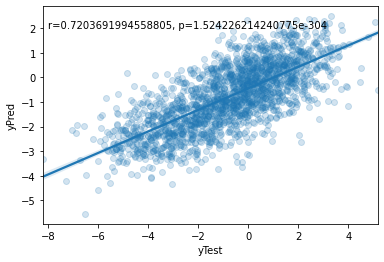

In [43]:
# plot of yTest vs yPred
g = sns.regplot(x = yTest, y = zzz, scatter_kws={'alpha':0.2})

# set axes labels
_ = plt.xlabel('yTest')
_ = plt.ylabel('yPred')

# pearson correlation test
r, p = stats.pearsonr(yTest, yPred)
_ = g.annotate('r={}, p={}'.format(r, p), (-8, 2))

Surprisingly, the pearson correlation was **0.72** with a significant p-value

Next, I would use a peak calling program to select the actual sequence to which the N_proteins bind on the RNA. Hopefully that would produce a model.

Text(0.5, 0, 'Kmer Encoding Type')

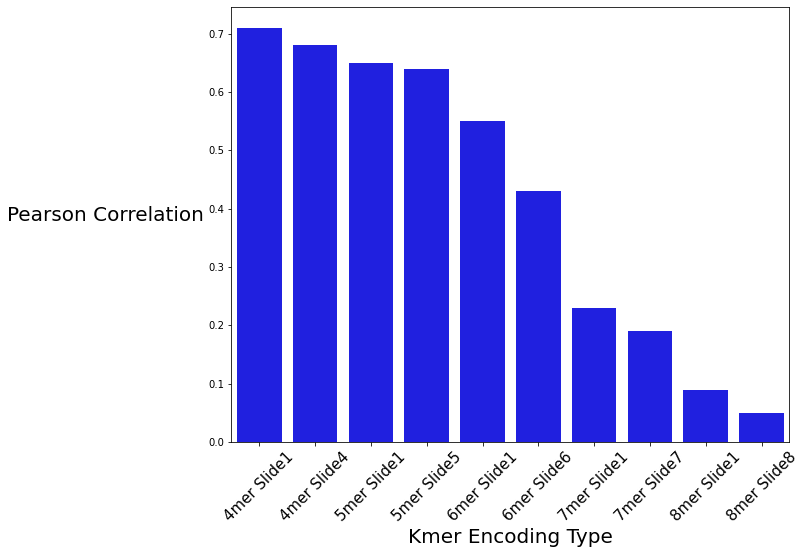

In [67]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Kmer Encoding', y='Pearson Correlation', data=kmer_data, color='blue')
plt.xticks(rotation=45, size=15)
plt.ylabel('Pearson Correlation                               ', size=20, rotation=360)
plt.xlabel('Kmer Encoding Type', size=20)